In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [5]:
from funcs_var import *

---

### Data Collection

#### short term interest rate

In [6]:
stir = pd.read_csv('var/short_term_int_rate_m.csv')

In [7]:
stir = stir[['TIME', 'Value']].copy()

#### inflation rate

In [8]:
ir_ = pd.read_csv('var/inflation_rate_m.csv')

In [9]:
ir = []
for i in range(len(ir_.iloc[:, 1:13])):
    ir = ir + ir_.iloc[i, 1:13].tolist()

In [10]:
ir = ir[:-9]

In [11]:
ir = [float(ir[i]) for i in range(len(ir))]

In [12]:
ir_dt = []
for i in range(len(ir)):
    y = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).year
    m = (datetime.strptime('1914-01', '%Y-%M') + relativedelta(months=i)).month
    ir_dt.append(str(y)+'-'+str(m))

In [13]:
ir = pd.DataFrame([ir_dt, ir], index=['TIME', 'Value']).T

#### unemployment rate

In [14]:
ur = pd.read_csv('var/unemployment_rate_m.csv')

In [15]:
ur = ur[['TIME', 'Value']].copy()

#### Make full df

In [16]:
ur[ur['TIME']=='1964-06']

,TIME,Value
113,1964-06,5.2


In [17]:
ir[ir['TIME']=='1964-6']

,TIME,Value
605,1964-6,1.3


In [18]:
stir.head()

,TIME,Value
0,1964-06,3.86
1,1964-07,3.87
2,1964-08,3.85
3,1964-09,3.87
4,1964-10,3.94


In [19]:
df_var = pd.concat([stir, 
           pd.DataFrame(ir.iloc[605:, 1]).reset_index(drop=True), 
           pd.DataFrame(ur.iloc[113:, 1]).reset_index(drop=True)], 
          axis=1)
df_var.columns = ['TIME','stir', 'infr', 'umpr']

---

### Stationarity part

In [20]:
df_var.head()

,TIME,stir,infr,umpr
0,1964-06,3.86,1.3,5.2
1,1964-07,3.87,1.3,4.9
2,1964-08,3.85,1,5.0
3,1964-09,3.87,1.3,5.1
4,1964-10,3.94,1,5.1


In [21]:
df_var = df_var.iloc[:-5, :].copy()

In [22]:
df_var_t = df_var.copy()
df_var_t['TIME'] = pd.to_datetime(df_var_t['TIME'])
df_var_t.index = df_var_t['TIME']

Results of Dickey-Fuller Test:
Test Statistic                  -2.169757
p-value                          0.217404
#Lags Used                      19.000000
Number of Observations Used    609.000000
Critical Value (10%)            -2.569304
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
dtype: float64


Results of KPSS Test:
Test Statistic            1.542907
p-value                   0.010000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


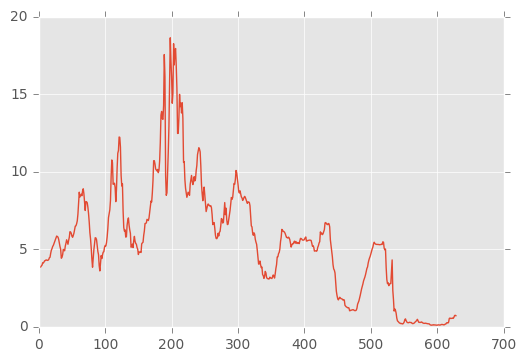

In [23]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.026327
p-value                          0.032508
#Lags Used                      18.000000
Number of Observations Used    610.000000
Critical Value (10%)            -2.569300
Critical Value (1%)             -3.441116
Critical Value (5%)             -2.866290
dtype: float64


Results of KPSS Test:
Test Statistic            1.154627
p-value                   0.010000
#Lags Used               20.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


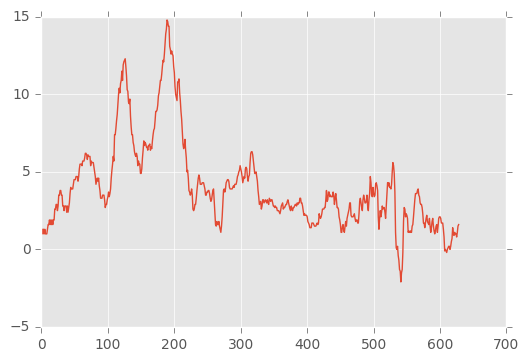

In [24]:
test_stationarity(df_var_t['infr'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.355673
p-value                          0.012566
#Lags Used                       6.000000
Number of Observations Used    622.000000
Critical Value (10%)            -2.569251
Critical Value (1%)             -3.440907
Critical Value (5%)             -2.866198
dtype: float64


Results of KPSS Test:
Test Statistic            0.24785
p-value                   0.10000
#Lags Used               20.00000
Critical Value (10%)      0.34700
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


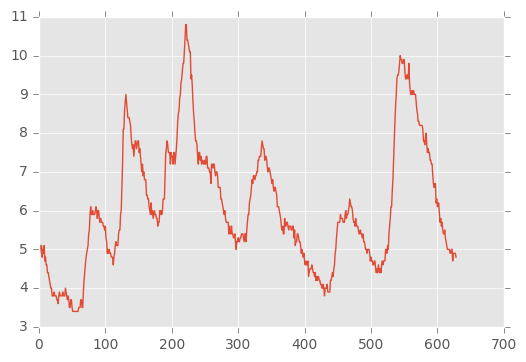

In [25]:
test_stationarity(df_var_t['umpr'])

Разности

Results of Dickey-Fuller Test:
Test Statistic                  -5.337747
p-value                          0.000005
#Lags Used                      18.000000
Number of Observations Used    609.000000
Critical Value (10%)            -2.569304
Critical Value (1%)             -3.441133
Critical Value (5%)             -2.866298
dtype: float64


Results of KPSS Test:
Test Statistic            0.082104
p-value                   0.100000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


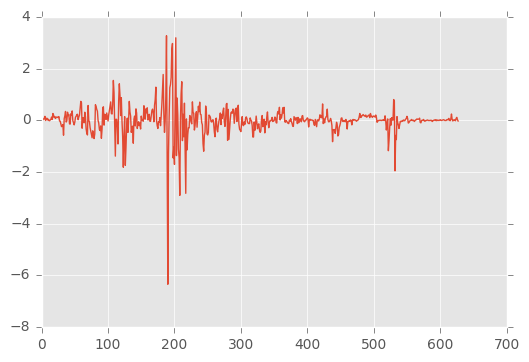

In [26]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -6.032762e+00
p-value                        1.405130e-07
#Lags Used                     1.400000e+01
Number of Observations Used    6.130000e+02
Critical Value (10%)          -2.569287e+00
Critical Value (1%)           -3.441063e+00
Critical Value (5%)           -2.866266e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.070892
p-value                   0.100000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


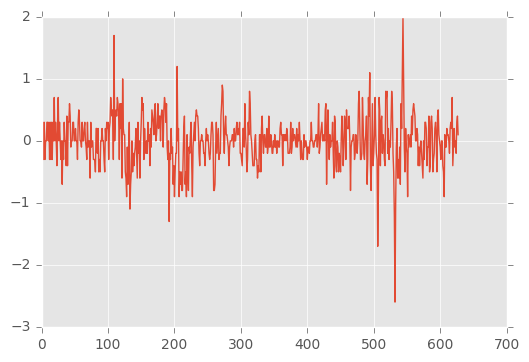

In [27]:
test_stationarity(diff_series(df_var_t['infr']))

Results of Dickey-Fuller Test:
Test Statistic                -5.880016e+00
p-value                        3.094187e-07
#Lags Used                     1.100000e+01
Number of Observations Used    6.160000e+02
Critical Value (10%)          -2.569275e+00
Critical Value (1%)           -3.441010e+00
Critical Value (5%)           -2.866243e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.055131
p-value                   0.100000
#Lags Used               19.000000
Critical Value (10%)      0.347000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


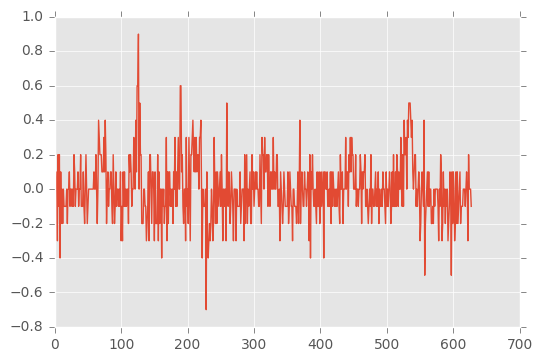

In [28]:
test_stationarity(diff_series(df_var_t['umpr']))

In [29]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

#### 6 steps

In [30]:
LAG = 2

In [31]:
STEPS = 8

In [32]:
train = df_var_t_diff.iloc[:-STEPS, 1:]
test = df_var_t_diff.iloc[-STEPS:, 1:]

train_real = df_var_t.iloc[:-STEPS, 1:]
test_real = df_var_t.iloc[-STEPS:, 1:]

### VAR

In [33]:
def var_model(train, steps, lags, years=None):
    df = np.array(train)
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [34]:
#years=train['TIME'][2:-6].reset_index(drop=True)
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:])

In [35]:
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['umpr'], test['umpr']))

{'mae': 0.043459022661314829, 'rmse': 0.056624101502901161, 'mse': 0.0032062888710108536}
{'mae': 0.16780082162714149, 'rmse': 0.21280279122627102, 'mse': 0.045285027953691888}
{'mae': 0.090575333915594594, 'rmse': 0.1383259751198512, 'mse': 0.019134075392857695}


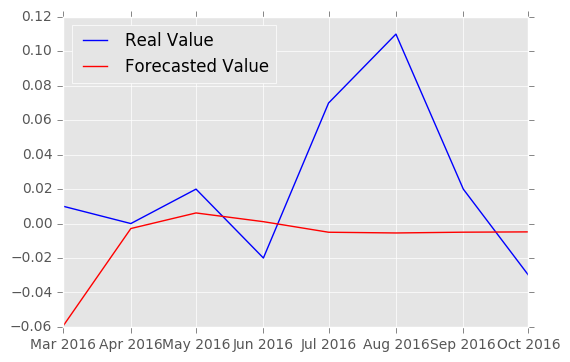

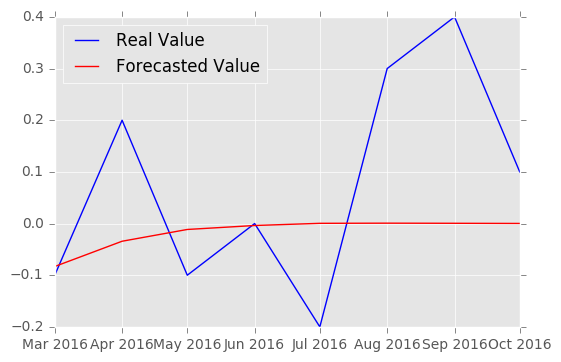

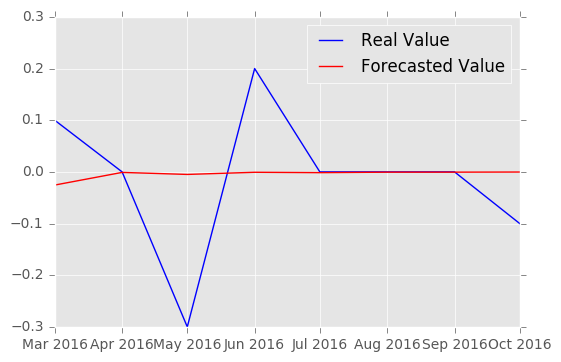

In [36]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['umpr'], test['umpr'])

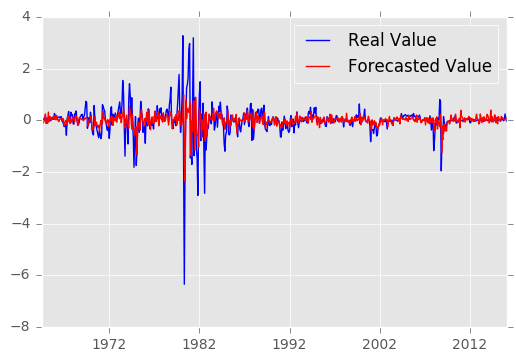

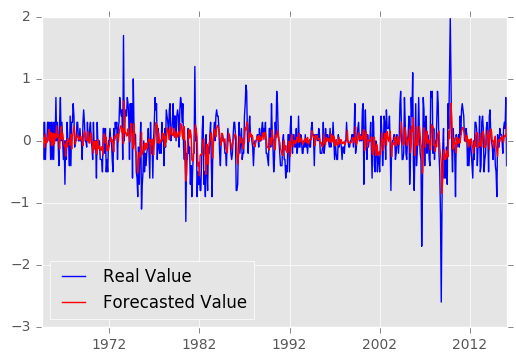

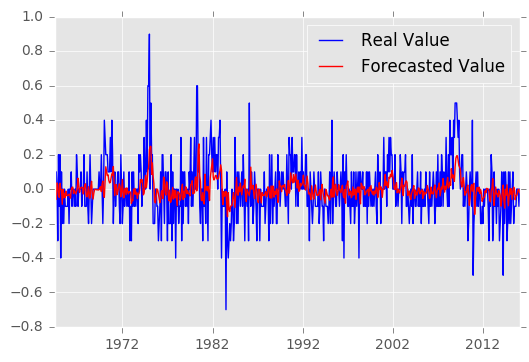

In [37]:
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['umpr'], train['umpr'])

In [38]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])

In [39]:
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])

In [40]:
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['umpr'], test_real['umpr']))

{'mae': 0.15282140490954163, 'rmse': 0.17677017912302981, 'mse': 0.031247696227188045}
{'mae': 0.26953688057418529, 'rmse': 0.36599205767985243, 'mse': 0.13395018628473243}
{'mae': 0.077544853898947164, 'rmse': 0.092831384890134261, 'mse': 0.0086176660206202464}


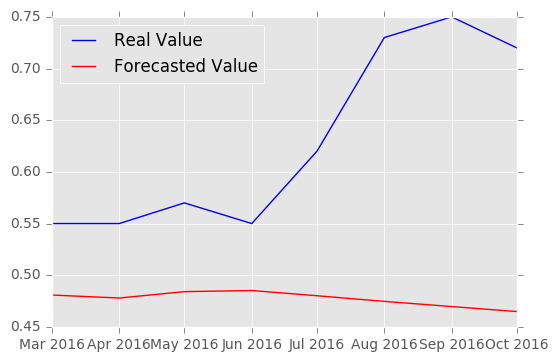

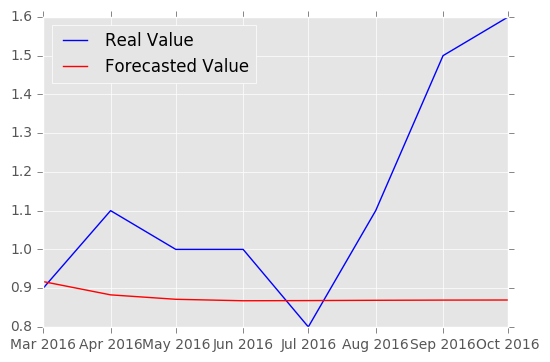

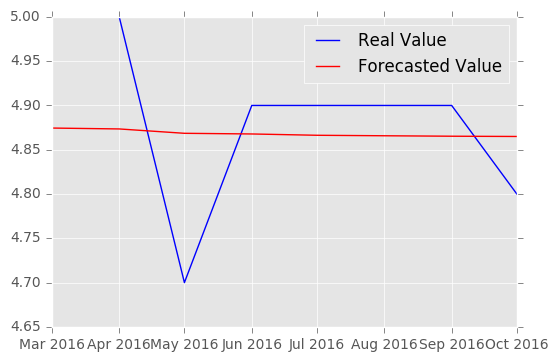

In [41]:
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['umpr'], test_real['umpr'])

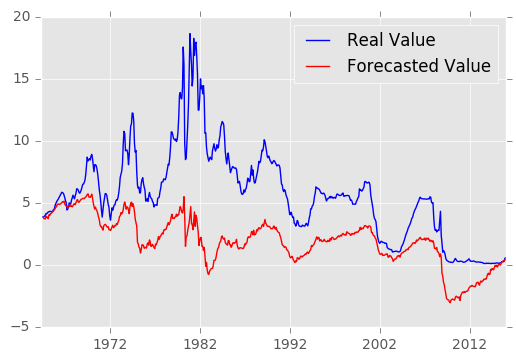

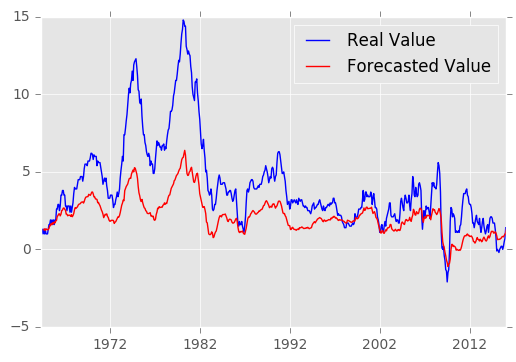

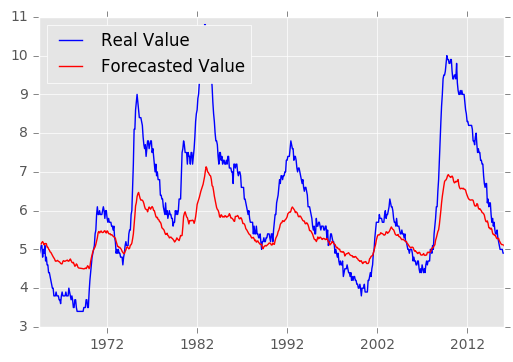

In [42]:
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['umpr'], train_real['umpr'])

### ANN

In [43]:
df_nn = nn_transform(train, n=LAG)

In [44]:
train_nn_x = df_nn.iloc[:, 3:].copy()
train_nn_y = df_nn.iloc[:, :3].copy()

Первый запуск модели для проверки ее устойчивости

In [45]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [46]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100):
    years_out=None
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(1, steps+1)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

In [47]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
1s - loss: 0.1761
Epoch 2/100
1s - loss: 0.1692
Epoch 3/100
1s - loss: 0.1664
Epoch 4/100
1s - loss: 0.1631
Epoch 5/100
1s - loss: 0.1606
Epoch 6/100
0s - loss: 0.1581
Epoch 7/100
1s - loss: 0.1542
Epoch 8/100
1s - loss: 0.1521
Epoch 9/100
0s - loss: 0.1499
Epoch 10/100
0s - loss: 0.1474
Epoch 11/100
1s - loss: 0.1458
Epoch 12/100
1s - loss: 0.1433
Epoch 13/100
0s - loss: 0.1431
Epoch 14/100
0s - loss: 0.1421
Epoch 15/100
0s - loss: 0.1414
Epoch 16/100
0s - loss: 0.1406
Epoch 17/100
0s - loss: 0.1404
Epoch 18/100
0s - loss: 0.1404
Epoch 19/100
0s - loss: 0.1396
Epoch 20/100
0s - loss: 0.1399
Epoch 21/100
0s - loss: 0.1393
Epoch 22/100
0s - loss: 0.1395
Epoch 23/100
0s - loss: 0.1400
Epoch 24/100
0s - loss: 0.1393
Epoch 25/100
0s - loss: 0.1385
Epoch 26/100
0s - loss: 0.1395
Epoch 27/100
0s - loss: 0.1390
Epoch 28/100
0s - loss: 0.1390
Epoch 29/100
0s - loss: 0.1388
Epoch 30/100
0s - loss: 0.1384
Epoch 31/100
0s - loss: 0.1388
Epoch 32/100
0s - loss: 0.1385
Epoch 33/100
0s -

In [48]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'mae': 0.048359662964940042, 'rmse': 0.05654978782989499, 'mse': 0.0031978785036061398}
{'mae': 0.16247697472572328, 'rmse': 0.20032439497386278, 'mse': 0.040129863221644177}
{'mae': 0.089321053214371227, 'rmse': 0.13631382995785948, 'mse': 0.018581460237780227}


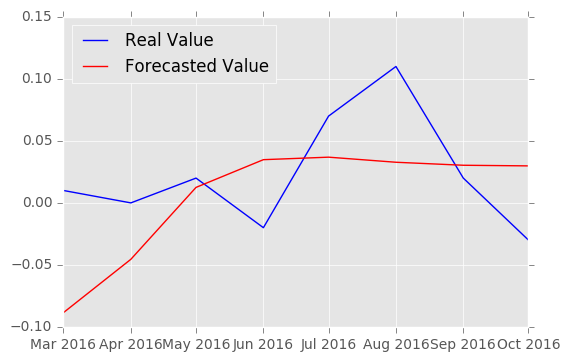

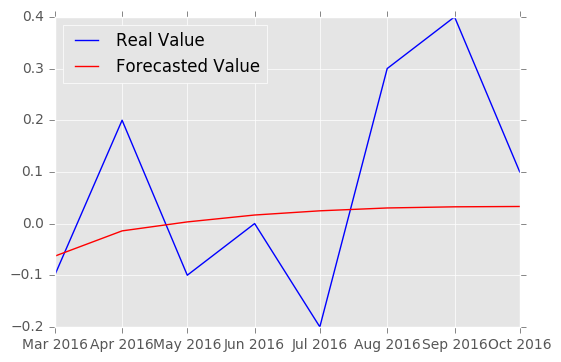

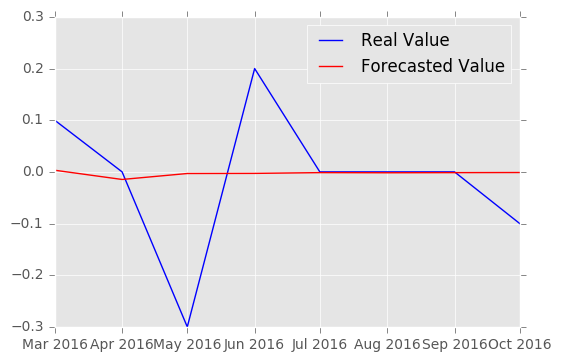

In [49]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])

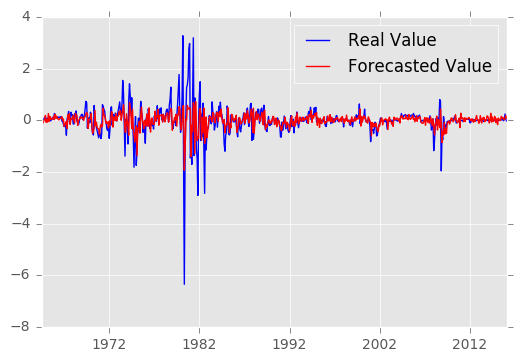

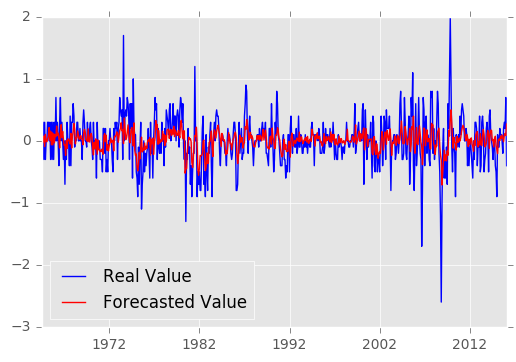

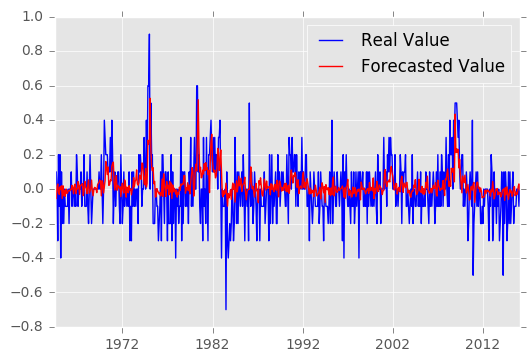

In [50]:
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

In [51]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))

{'mae': 0.14509292893111703, 'rmse': 0.14990476356342228, 'mse': 0.022471438139005533}
{'mae': 0.20291540462058039, 'rmse': 0.2715650975233056, 'mse': 0.073747602192842487}
{'mae': 0.068685063160955906, 'rmse': 0.089184814039814611, 'mse': 0.0079539310553163132}


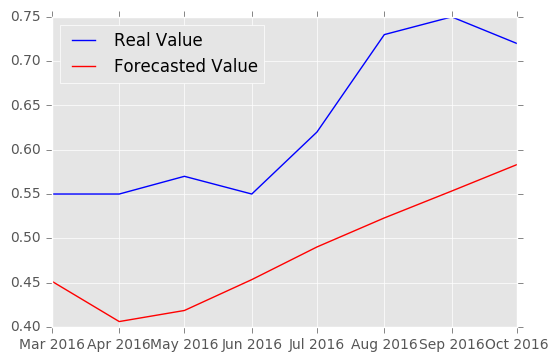

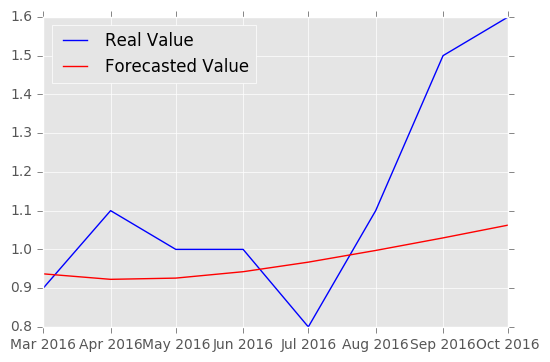

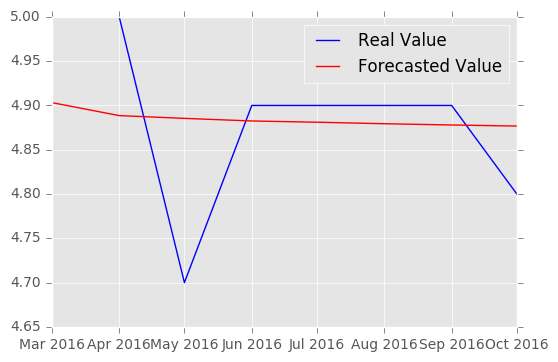

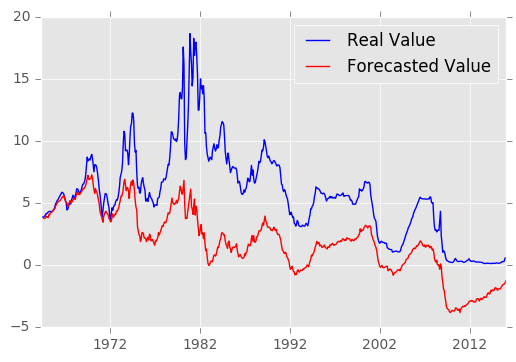

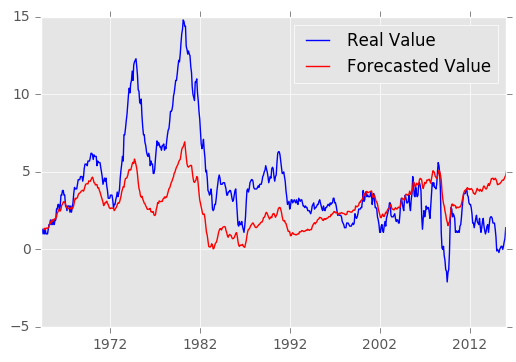

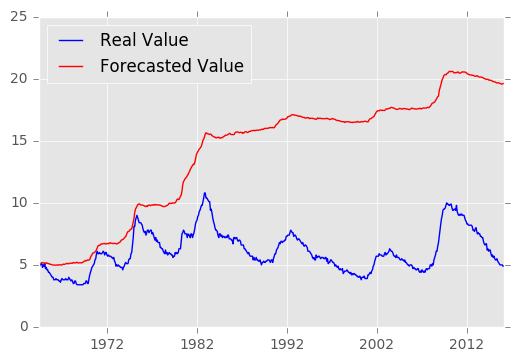

In [52]:
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

Второй запуск модели

In [53]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [54]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=100)

Epoch 1/100
1s - loss: 0.2358
Epoch 2/100
0s - loss: 0.1669
Epoch 3/100
0s - loss: 0.1637
Epoch 4/100
0s - loss: 0.1610
Epoch 5/100
0s - loss: 0.1580
Epoch 6/100
0s - loss: 0.1559
Epoch 7/100
0s - loss: 0.1538
Epoch 8/100
0s - loss: 0.1514
Epoch 9/100
0s - loss: 0.1503
Epoch 10/100
0s - loss: 0.1483
Epoch 11/100
0s - loss: 0.1474
Epoch 12/100
0s - loss: 0.1455
Epoch 13/100
0s - loss: 0.1449
Epoch 14/100
0s - loss: 0.1437
Epoch 15/100
0s - loss: 0.1423
Epoch 16/100
0s - loss: 0.1430
Epoch 17/100
0s - loss: 0.1425
Epoch 18/100
0s - loss: 0.1415
Epoch 19/100
0s - loss: 0.1414
Epoch 20/100
0s - loss: 0.1411
Epoch 21/100
0s - loss: 0.1410
Epoch 22/100
0s - loss: 0.1407
Epoch 23/100
0s - loss: 0.1404
Epoch 24/100
0s - loss: 0.1404
Epoch 25/100
0s - loss: 0.1397
Epoch 26/100
0s - loss: 0.1401
Epoch 27/100
0s - loss: 0.1401
Epoch 28/100
0s - loss: 0.1400
Epoch 29/100
0s - loss: 0.1388
Epoch 30/100
1s - loss: 0.1392
Epoch 31/100
0s - loss: 0.1386
Epoch 32/100
0s - loss: 0.1394
Epoch 33/100
0s -

In [55]:
print(error(nn_result['out']['stir'], test['stir']))
print(error(nn_result['out']['infr'], test['infr']))
print(error(nn_result['out']['umpr'], test['umpr']))

{'mae': 0.088637841418385516, 'rmse': 0.10104471088327188, 'mse': 0.010210033597484004}
{'mae': 0.16145781390368941, 'rmse': 0.20332381037433006, 'mse': 0.041340571865136531}
{'mae': 0.096424130350351356, 'rmse': 0.13674760974998321, 'mse': 0.018699908772333702}


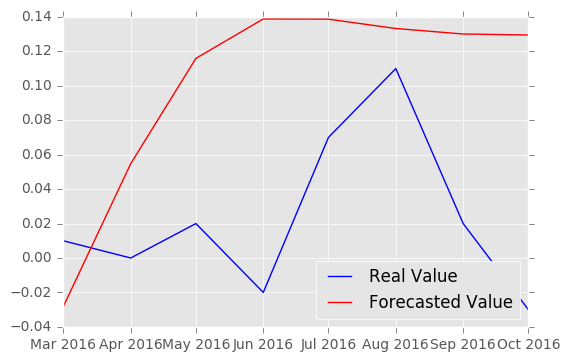

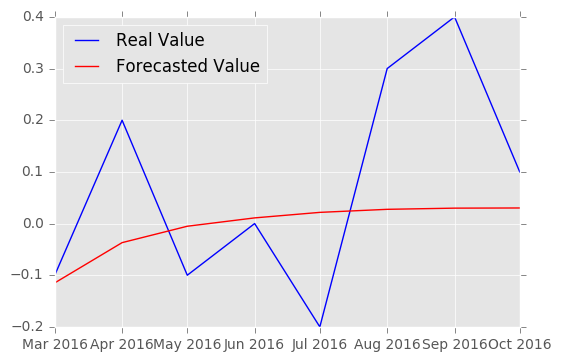

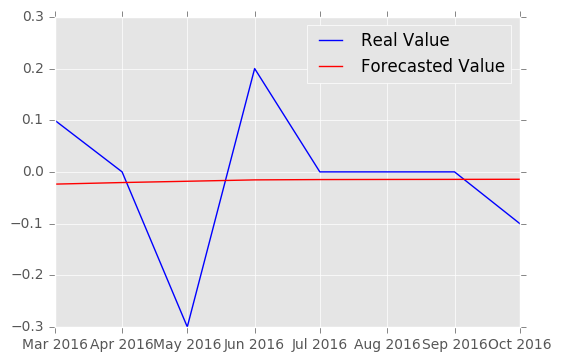

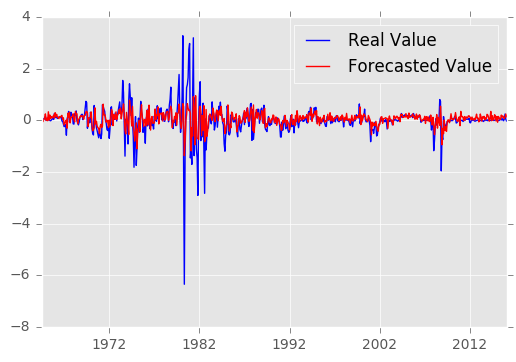

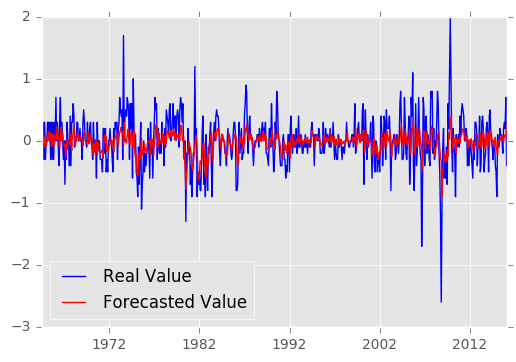

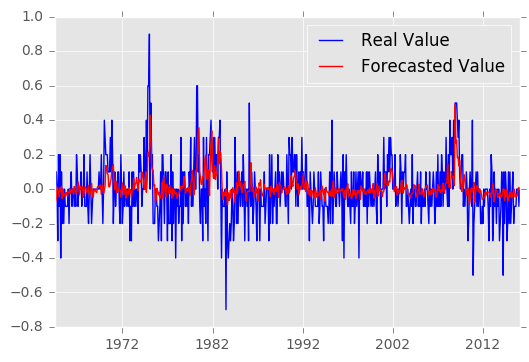

In [56]:
plot_compar(nn_result['out']['stir'], test['stir'])
plot_compar(nn_result['out']['infr'], test['infr'])
plot_compar(nn_result['out']['umpr'], test['umpr'])
plot_compar(nn_result['in']['stir'], train['stir'])
plot_compar(nn_result['in']['infr'], train['infr'])
plot_compar(nn_result['in']['umpr'], train['umpr'])

{'mae': 0.28101573549211029, 'rmse': 0.34643459711291374, 'mse': 0.12001693007678686}
{'mae': 0.25574413053691392, 'rmse': 0.33187332834468602, 'mse': 0.11013990606657979}
{'mae': 0.10522613245993839, 'rmse': 0.1103642505450092, 'mse': 0.012180267798361564}


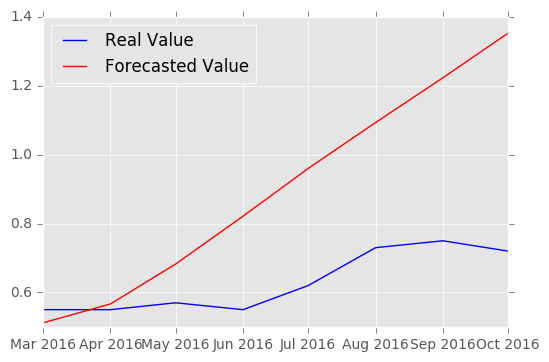

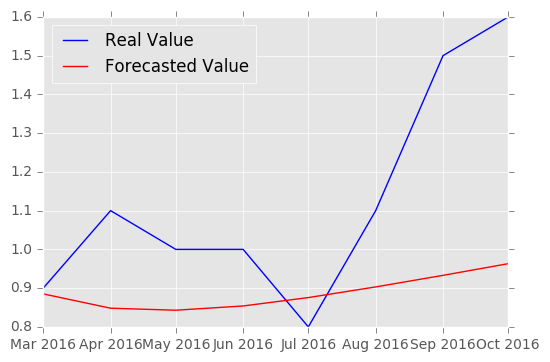

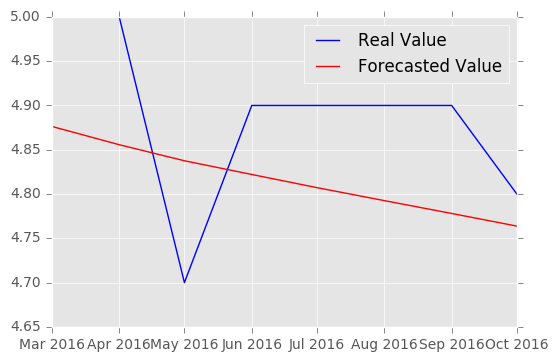

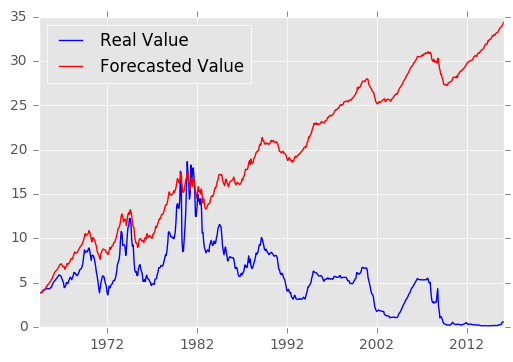

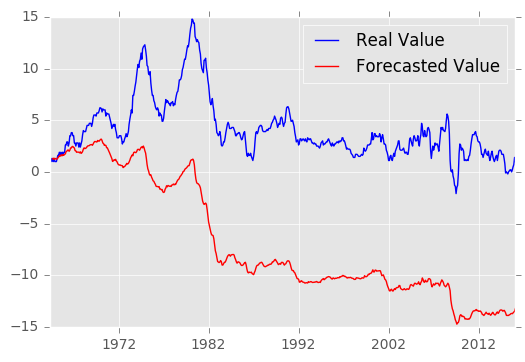

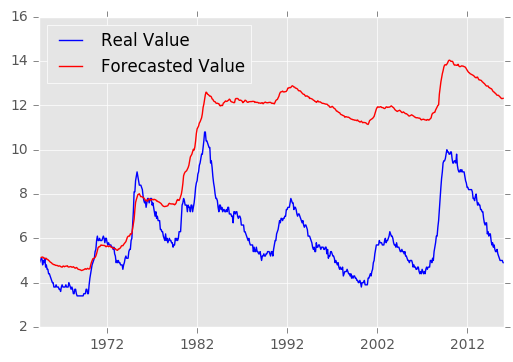

In [57]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['umpr'], test_real['umpr']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['umpr'], test_real['umpr'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['umpr'], train_real['umpr'])

### Hybrid

In [58]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    train_nn_x = df_nn.iloc[:, n_feat:].copy()
    train_nn_y = df_nn.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    
    hybrid_result = pd.DataFrame(var_result + nn_result.as_matrix())
    hybrid_result.columns = train.columns
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(1, steps+1)]
        hybrid_result.index = ind
    return hybrid_result

In [59]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [60]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.1489
Epoch 2/10
0s - loss: 0.1416
Epoch 3/10
0s - loss: 0.1417
Epoch 4/10
0s - loss: 0.1414
Epoch 5/10
0s - loss: 0.1411
Epoch 6/10
0s - loss: 0.1414
Epoch 7/10
0s - loss: 0.1402
Epoch 8/10
0s - loss: 0.1413
Epoch 9/10
0s - loss: 0.1411
Epoch 10/10
0s - loss: 0.1409


Первый запуск

In [61]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mae': 0.062958383664012491, 'rmse': 0.078393115971384805, 'mse': 0.0061454806317029868}
{'mae': 0.17428246422915306, 'rmse': 0.22262174493569603, 'mse': 0.049560441318214105}
{'mae': 0.11816506518239618, 'rmse': 0.15276657439975833, 'mse': 0.0233376262538369}


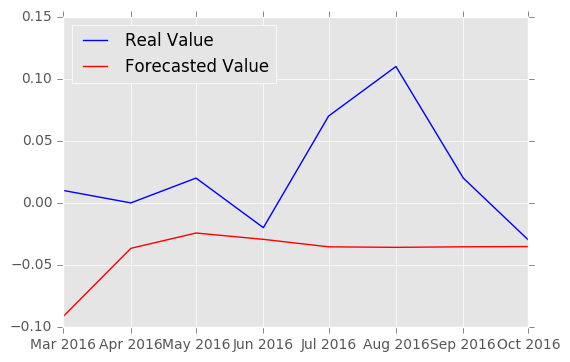

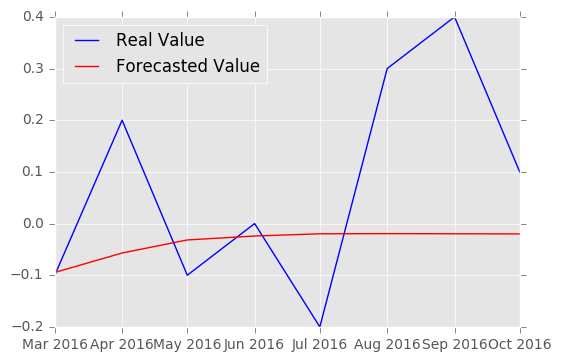

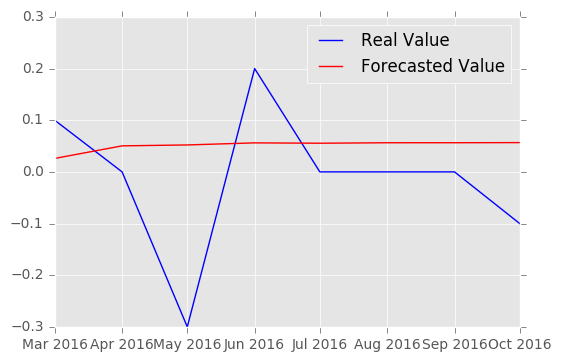

In [62]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mae': 0.29449302242492681, 'rmse': 0.33281154051038425, 'mse': 0.11076352149689514}
{'mae': 0.33440997106353343, 'rmse': 0.45206337957617104, 'mse': 0.20436129915382928}
{'mae': 0.25131259440359255, 'rmse': 0.2911821449112027, 'mse': 0.084787041515088646}


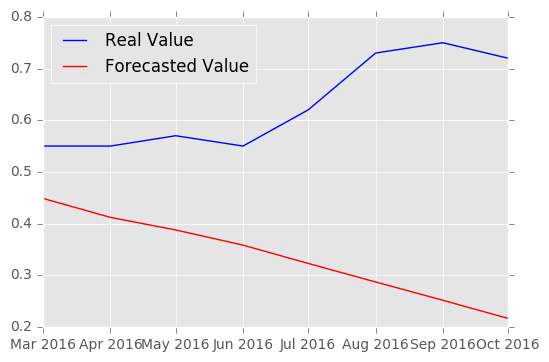

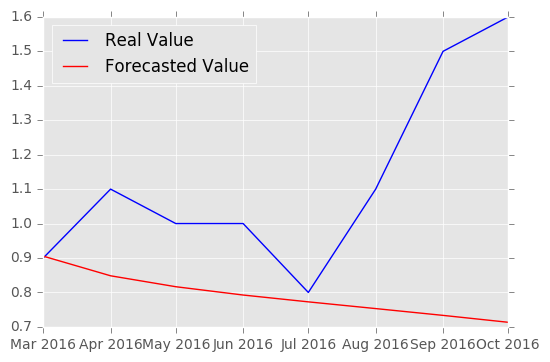

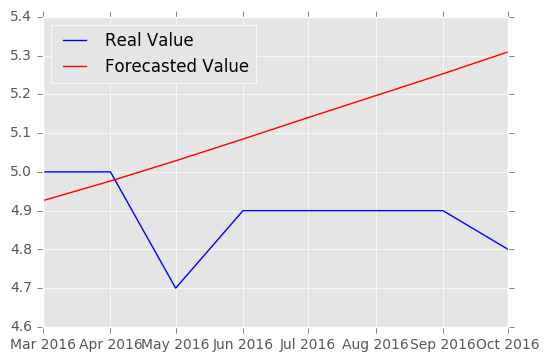

In [63]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

Второй запуск

In [64]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.1591
Epoch 2/10
0s - loss: 0.1412
Epoch 3/10
0s - loss: 0.1412
Epoch 4/10
0s - loss: 0.1412
Epoch 5/10
0s - loss: 0.1414
Epoch 6/10
0s - loss: 0.1415
Epoch 7/10
0s - loss: 0.1414
Epoch 8/10
0s - loss: 0.1404
Epoch 9/10
0s - loss: 0.1415
Epoch 10/10
0s - loss: 0.1404


In [65]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mae': 0.10842991314035706, 'rmse': 0.11747015158284037, 'mse': 0.013799236512895495}
{'mae': 0.16618041161692287, 'rmse': 0.2124789413790299, 'mse': 0.045147300529553222}
{'mae': 0.10160762094700673, 'rmse': 0.13997380819093594, 'mse': 0.019592666979472921}


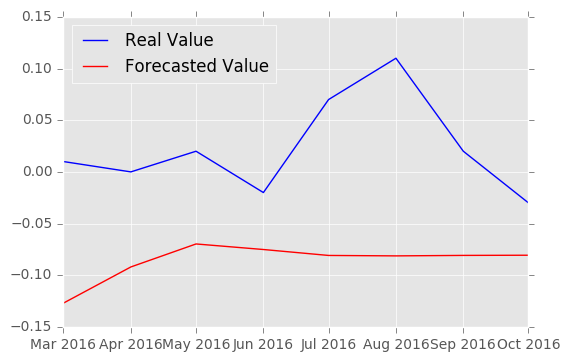

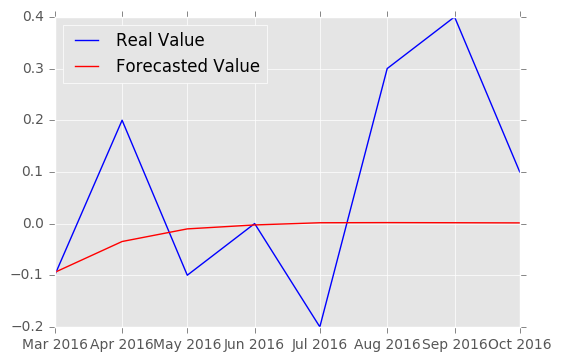

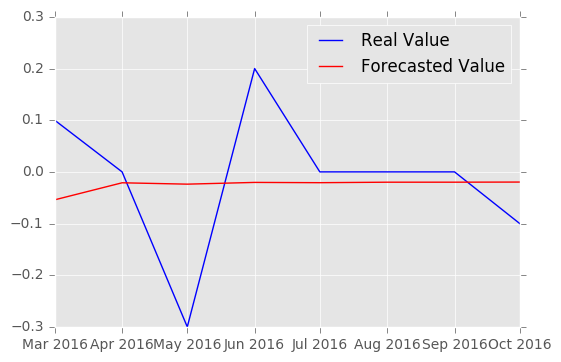

In [66]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mae': 0.49791896907036548, 'rmse': 0.56125033330358598, 'mse': 0.31500193663338633}
{'mae': 0.27348496372159187, 'rmse': 0.37089884515726546, 'mse': 0.13756595333899319}
{'mae': 0.1411944528793434, 'rmse': 0.14425672455539729, 'mse': 0.020810002579451765}


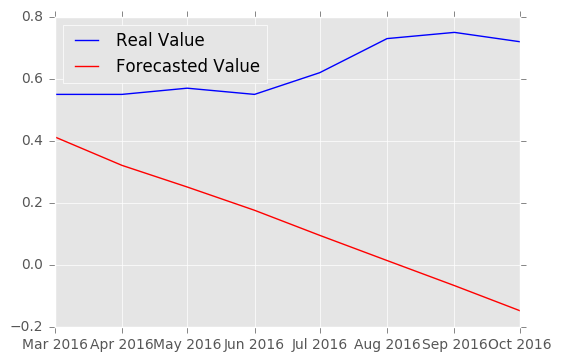

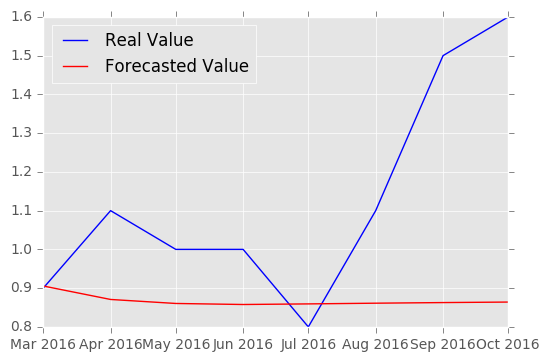

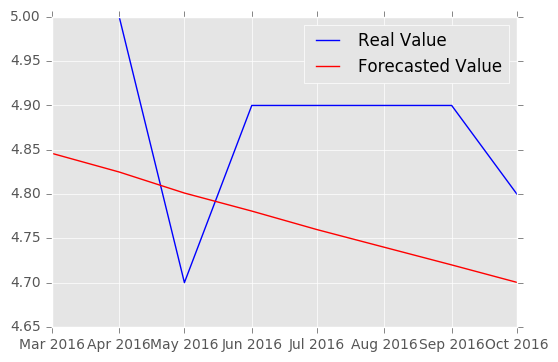

In [67]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

С DropOut

In [68]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.3456
Epoch 2/10
1s - loss: 0.1853
Epoch 3/10
1s - loss: 0.1554
Epoch 4/10
0s - loss: 0.1494
Epoch 5/10
0s - loss: 0.1446
Epoch 6/10
1s - loss: 0.1442
Epoch 7/10
0s - loss: 0.1432
Epoch 8/10
1s - loss: 0.1419
Epoch 9/10
1s - loss: 0.1413
Epoch 10/10
1s - loss: 0.1410


In [69]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['umpr'], test['umpr']))

{'mae': 0.043668026348219736, 'rmse': 0.056423927208613882, 'mse': 0.0031836595616429575}
{'mae': 0.16919083919620659, 'rmse': 0.21454686953996188, 'mse': 0.046030359229397425}
{'mae': 0.090086505400813366, 'rmse': 0.13817062700558291, 'mse': 0.01909112216711592}


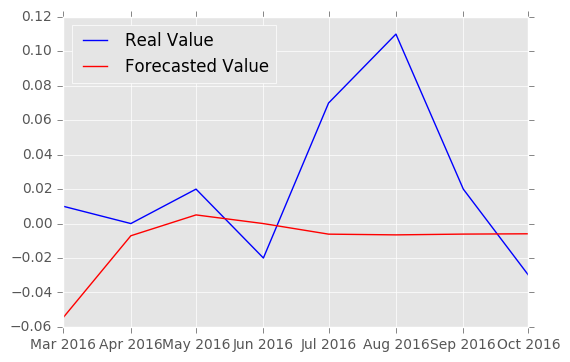

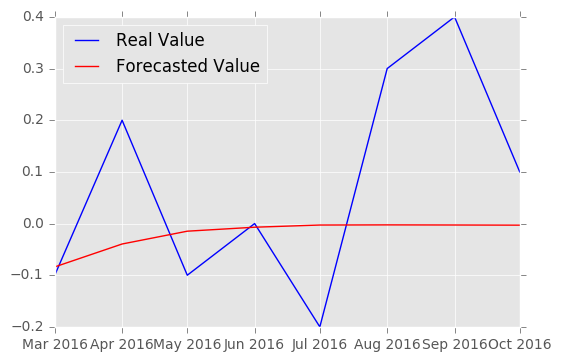

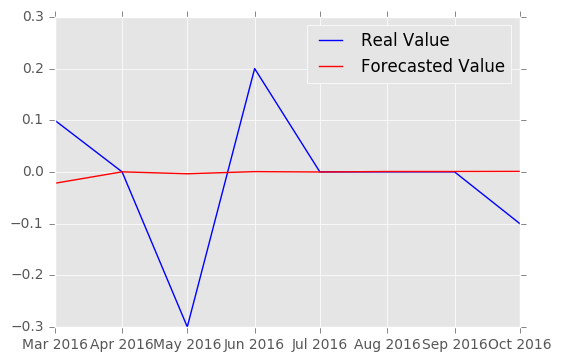

In [70]:
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['umpr'], test['umpr'])

{'mae': 0.15465230220352652, 'rmse': 0.17970227589387397, 'mse': 0.032292907961438001}
{'mae': 0.27950127076636616, 'rmse': 0.38008490240691034, 'mse': 0.14446453303767054}
{'mae': 0.074298536514182612, 'rmse': 0.092593206674843789, 'mse': 0.0085735019223303361}


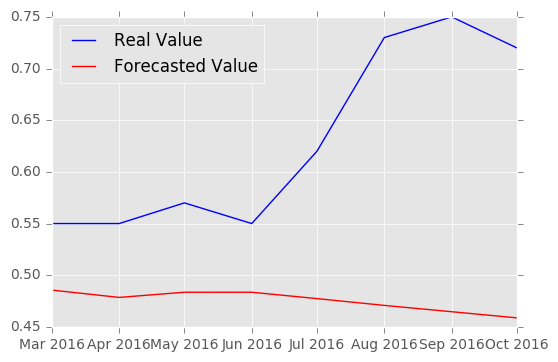

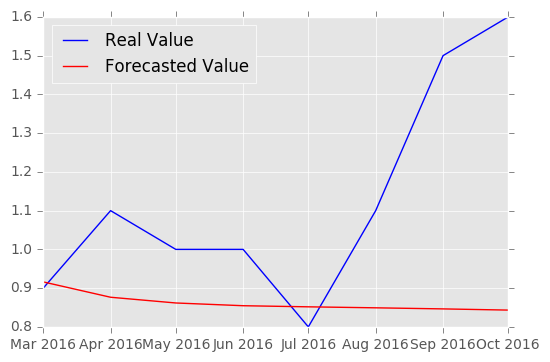

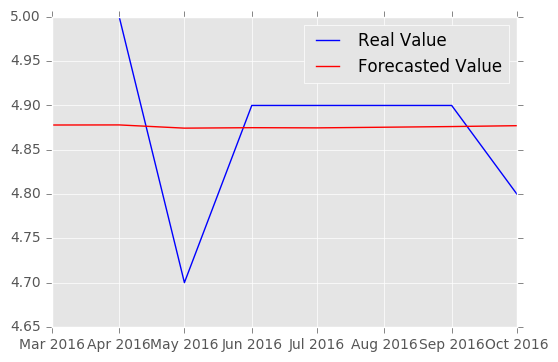

In [71]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

C DropOut 2

In [72]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=10)

Epoch 1/10
1s - loss: 0.3129
Epoch 2/10
1s - loss: 0.1738
Epoch 3/10
0s - loss: 0.1550
Epoch 4/10
0s - loss: 0.1467
Epoch 5/10
0s - loss: 0.1444
Epoch 6/10
1s - loss: 0.1434
Epoch 7/10
1s - loss: 0.1420
Epoch 8/10
1s - loss: 0.1428
Epoch 9/10
1s - loss: 0.1417
Epoch 10/10
1s - loss: 0.1405


{'mae': 0.15514166227431389, 'rmse': 0.17931018896235548, 'mse': 0.032152143865715625}
{'mae': 0.26241387127246324, 'rmse': 0.3557436991512381, 'mse': 0.12655357948580662}
{'mae': 0.082933396210213228, 'rmse': 0.094739876018592961, 'mse': 0.0089756441080183665}


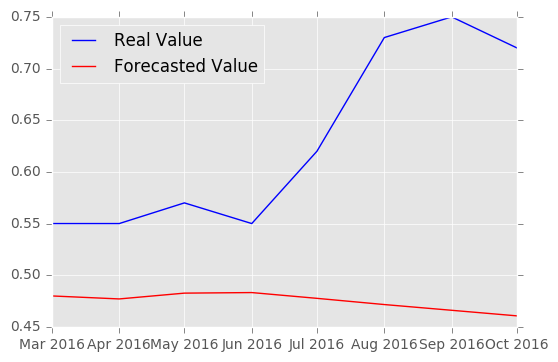

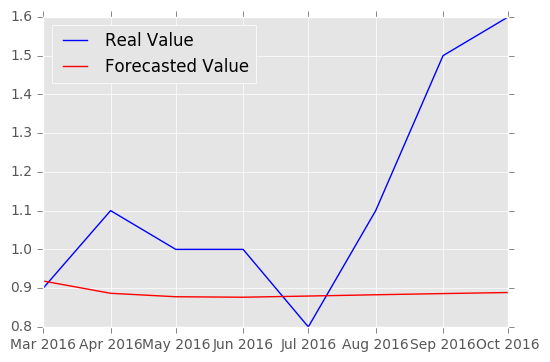

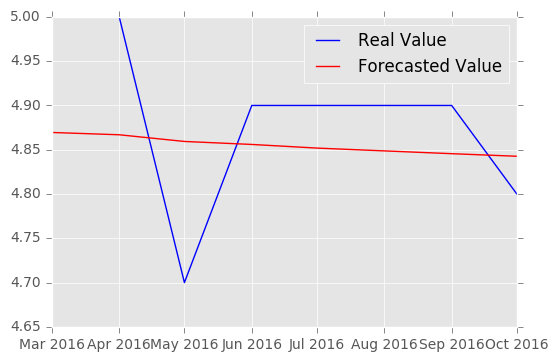

In [73]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['umpr'], test_real['umpr']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['umpr'], test_real['umpr'])

### Hybrid Full

In [74]:
def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [75]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.8099
Epoch 2/500
0s - loss: 0.4623
Epoch 3/500
0s - loss: 0.2745
Epoch 4/500
0s - loss: 0.1867
Epoch 5/500
0s - loss: 0.1355
Epoch 6/500
1s - loss: 0.1000
Epoch 7/500
0s - loss: 0.0791
Epoch 8/500
1s - loss: 0.0679
Epoch 9/500
0s - loss: 0.0621
Epoch 10/500
0s - loss: 0.0584
Epoch 11/500
0s - loss: 0.0554
Epoch 12/500
0s - loss: 0.0533
Epoch 13/500
0s - loss: 0.0511
Epoch 14/500
0s - loss: 0.0492
Epoch 15/500
0s - loss: 0.0480
Epoch 16/500
0s - loss: 0.0465
Epoch 17/500
0s - loss: 0.0455
Epoch 18/500
0s - loss: 0.0447
Epoch 19/500
0s - loss: 0.0436
Epoch 20/500
0s - loss: 0.0427
Epoch 21/500
0s - loss: 0.0422
Epoch 22/500
0s - loss: 0.0414
Epoch 23/500
0s - loss: 0.0413
Epoch 24/500
1s - loss: 0.0403
Epoch 25/500
0s - loss: 0.0402
Epoch 26/500
0s - loss: 0.0401
Epoch 27/500
0s - loss: 0.0395
Epoch 28/500
0s - loss: 0.0384
Epoch 29/500
0s - loss: 0.0387
Epoch 30/500
0s - loss: 0.0376
Epoch 31/500
1s - loss: 0.0375
Epoch 32/500
1s - loss: 0.0379
Epoch 33/500
1s -

{'mae': 4.3244624903689717, 'rmse': 4.3391575778524638, 'mse': 18.828288485434463}
{'mae': 1.3223727980666433, 'rmse': 1.3341570088441776, 'mse': 1.7799749242480432}
{'mae': 0.36262035009711724, 'rmse': 0.37350907972780306, 'mse': 0.13950903263911035}


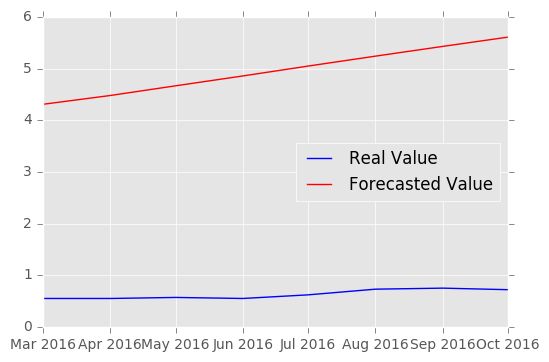

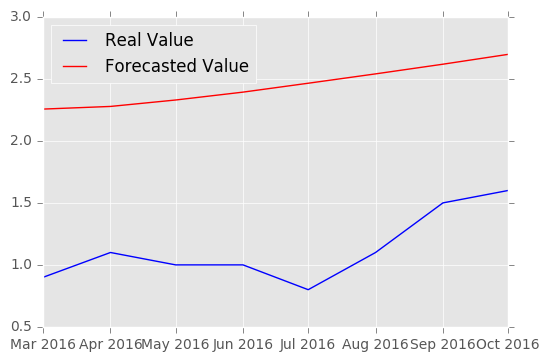

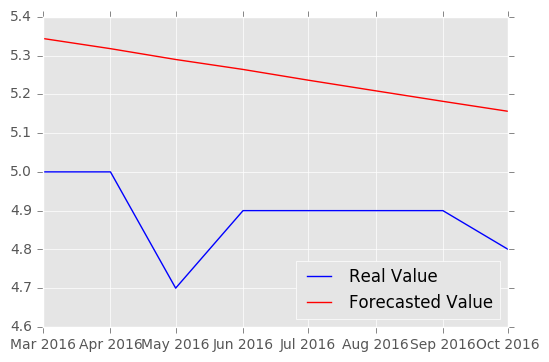

In [76]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

Второй запуск

In [77]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
1s - loss: 0.9205
Epoch 2/500
1s - loss: 0.5388
Epoch 3/500
1s - loss: 0.3383
Epoch 4/500
1s - loss: 0.2434
Epoch 5/500
1s - loss: 0.1861
Epoch 6/500
1s - loss: 0.1437
Epoch 7/500
1s - loss: 0.1083
Epoch 8/500
1s - loss: 0.0843
Epoch 9/500
1s - loss: 0.0718
Epoch 10/500
1s - loss: 0.0643
Epoch 11/500
1s - loss: 0.0598
Epoch 12/500
1s - loss: 0.0572
Epoch 13/500
1s - loss: 0.0536
Epoch 14/500
1s - loss: 0.0519
Epoch 15/500
1s - loss: 0.0498
Epoch 16/500
1s - loss: 0.0489
Epoch 17/500
1s - loss: 0.0475
Epoch 18/500
1s - loss: 0.0458
Epoch 19/500
1s - loss: 0.0448
Epoch 20/500
1s - loss: 0.0439
Epoch 21/500
1s - loss: 0.0432
Epoch 22/500
1s - loss: 0.0426
Epoch 23/500
1s - loss: 0.0418
Epoch 24/500
1s - loss: 0.0412
Epoch 25/500
1s - loss: 0.0406
Epoch 26/500
1s - loss: 0.0399
Epoch 27/500
1s - loss: 0.0396
Epoch 28/500
1s - loss: 0.0392
Epoch 29/500
1s - loss: 0.0393
Epoch 30/500
1s - loss: 0.0384
Epoch 31/500
1s - loss: 0.0381
Epoch 32/500
1s - loss: 0.0376
Epoch 33/500
1s -

{'mae': 3.8425919265314494, 'rmse': 3.8438703947525585, 'mse': 14.775339611655189}
{'mae': 1.0808211078979288, 'rmse': 1.1185852390651811, 'mse': 1.2512329370545086}
{'mae': 0.49879941310261811, 'rmse': 0.51043323182326383, 'mse': 0.26054208414954183}


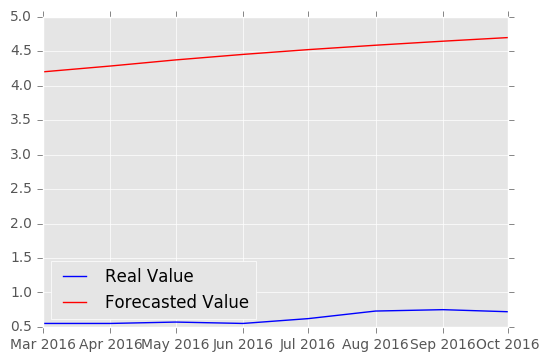

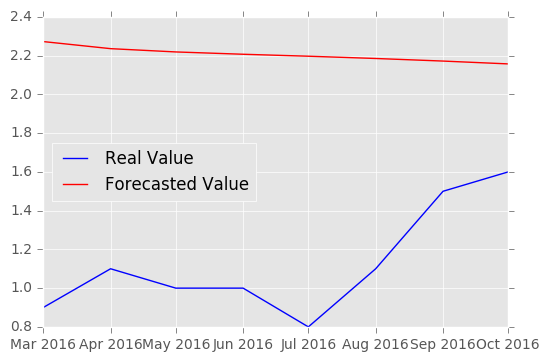

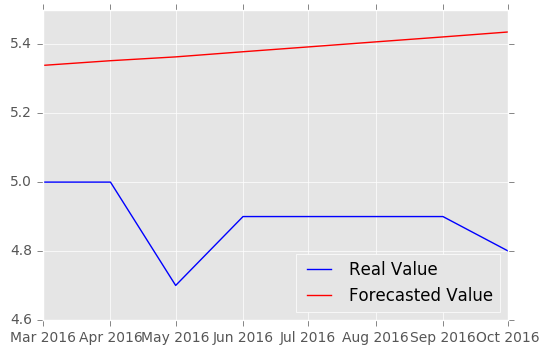

In [78]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])

С DropOut

In [79]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='m')

Epoch 1/500
2s - loss: 1.0660
Epoch 2/500
1s - loss: 0.9590
Epoch 3/500
1s - loss: 0.8663
Epoch 4/500
1s - loss: 0.7502
Epoch 5/500
1s - loss: 0.6631
Epoch 6/500
1s - loss: 0.6461
Epoch 7/500
1s - loss: 0.6337
Epoch 8/500
1s - loss: 0.6006
Epoch 9/500
1s - loss: 0.6177
Epoch 10/500
1s - loss: 0.6156
Epoch 11/500
1s - loss: 0.5766
Epoch 12/500
1s - loss: 0.5797
Epoch 13/500
1s - loss: 0.5885
Epoch 14/500
1s - loss: 0.5698
Epoch 15/500
1s - loss: 0.5805
Epoch 16/500
1s - loss: 0.5889
Epoch 17/500
1s - loss: 0.5756
Epoch 18/500
1s - loss: 0.5447
Epoch 19/500
1s - loss: 0.5494
Epoch 20/500
1s - loss: 0.5682
Epoch 21/500
1s - loss: 0.5256
Epoch 22/500
1s - loss: 0.5268
Epoch 23/500
1s - loss: 0.5456
Epoch 24/500
1s - loss: 0.5509
Epoch 25/500
1s - loss: 0.5368
Epoch 26/500
1s - loss: 0.5235
Epoch 27/500
1s - loss: 0.5359
Epoch 28/500
1s - loss: 0.5462
Epoch 29/500
1s - loss: 0.5511
Epoch 30/500
1s - loss: 0.5104
Epoch 31/500
1s - loss: 0.5175
Epoch 32/500
1s - loss: 0.5220
Epoch 33/500
1s -

{'mae': 2.7038375864225919, 'rmse': 2.7117784485468319, 'mse': 7.3537423540030638}
{'mae': 0.95990440474925465, 'rmse': 1.010096982846679, 'mse': 1.0202959147559643}
{'mae': 0.081206616074273819, 'rmse': 0.092774282224968252, 'mse': 0.0086070674423580594}


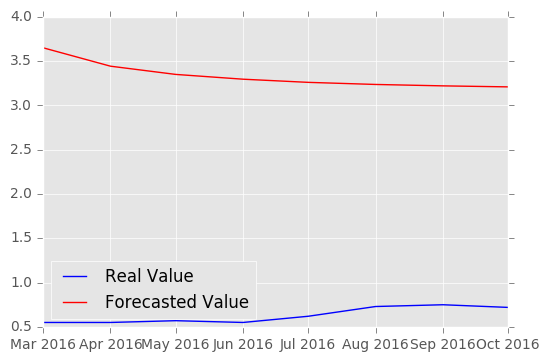

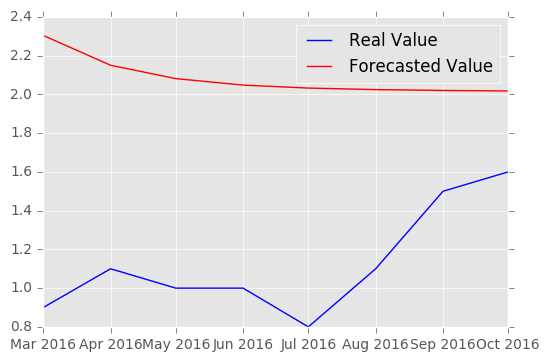

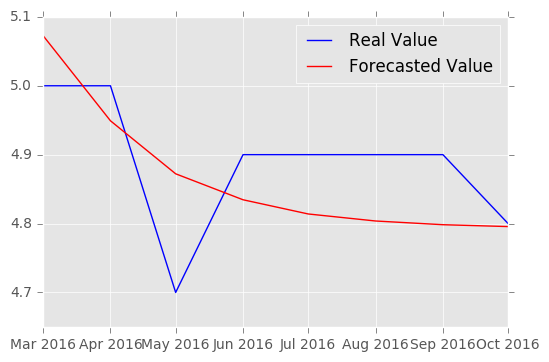

In [81]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['umpr'], test_real['umpr']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['umpr'], test_real['umpr'])